### Plot the magnetization of a halbach array, and add the magnetization of shimming sphere

In [1]:
from latticeOptimizer import LatticeOptimizer
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import numpy as np
from elementPT import CombinerHalbachLensSim,HalbachLensSim
import time
from SwarmTracerClass import SwarmTracer
import multiprocess as mp
from optimizerHelperFunctions import generate_Ring_And_Injector_Lattice


def solve(lensPoints):
    X=np.array([0.00976065, 0.03458421, 0.01329697, 0.01013278, 0.39046408])
    tuning=None
    PTL_Ring,PTL_Injector=generate_Ring_And_Injector_Lattice(X,tuning)

    # PTL_Ring.bender1.numPointsBoreAp=boreApPoints
    # PTL_Ring.bender1.build()
    # PTL_Ring.bender2.numPointsBoreAp=boreApPoints
    # PTL_Ring.bender2.build()
    for el in PTL_Ring:
        if type(el)==HalbachLensSim:
            el.numGridPointsZ = lensPoints
            # el.numGridPointsXY = lensPoints
            el.build()
    for el in PTL_Injector:
        if type(el)==HalbachLensSim:
            el.numGridPointsZ = lensPoints
            # el.numGridPointsXY = lensPoints
            el.build()

    optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
    optimizer.numParticlesFullSwarm=1000
    elementIndices=(0,6)
    ringTuningBounds = [(0.0, 1.5)]*2
    injectorTuningBounds = [(.01, .4), (.01, .4)]


    fastMode=True
    h=5e-6
    optimizer.generate_Swarms()
    swarm=optimizer.swarmInjectorInitial
    swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
        swarm
        , h, 1.0, parallel=False,
        fastMode=fastMode, copySwarm=True,
        accelerated=True,energyCorrection=False,stepsBetweenLogging=4)
    swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=True)
    swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)

    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                                                                        fastMode=fastMode, accelerated=True, copySwarm=True,stepsBetweenLogging=4)

    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=optimizer.T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return swarmFluxMult/maxFluxMult
def wrapper(x):
    try:
        return solve(x)
    except:
        return np.nan
pointsList=list(range(15,40,2))
with mp.Pool(9) as pool:
    results=pool.map(wrapper,pointsList,chunksize=1)

#combiner, 25
#bender, -5
#lens

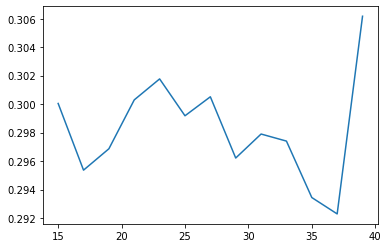

[0.3000470888006753,
 0.29536476997586436,
 0.2968651771293001,
 0.3002994272373316,
 0.3017708937522863,
 0.2991829839986961,
 0.30051609792308487,
 0.2962158054621431,
 0.2979008646942695,
 0.2974043448049352,
 0.2934410559663206,
 0.29229058340241615,
 0.3061724664411843]

In [2]:
plt.plot(pointsList,results)
plt.show()
results

[ 0.92369335 -0.3831326 ] [ 0.92369335 -0.3831326 ]
[ 0.92369335 -0.3831326 ] [-0.13004411  0.99150821]
[ 0.92369335 -0.3831326 ] [-0.79364924 -0.60837561]


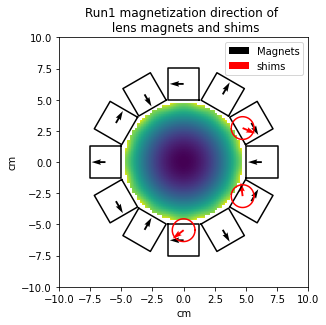

In [322]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.affinity import rotate
from HalbachLensClass import Layer

rp=(.05,)
width=.0254

thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # location of 12 magnets
thetaArr=thetaArr.reshape(-1,len(rp)).T
phiArr = np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization
phiArr=phiArr.reshape(-1,len(rp)).T
quiverData=[]
for r,r_phi,r_theta in zip(rp,phiArr,thetaArr):
    for phi,theta in zip(r_phi,r_theta):
        x,y=(r+width/2)*np.cos(theta)*1e2,(r+width/2)*np.sin(theta)*1e2
        quiverData.append([x,y,np.cos(phi),np.sin(phi)])
quiverData=np.asarray(quiverData)

squareCoords=np.asarray([(rp[0],-width/2),(rp[0]+width,-width/2),(rp[0]+width,width/2),(rp[0],width/2)])*1e2
squareOriginal=Polygon(squareCoords)
angleArr=np.linspace(0,np.pi*2,13)[:-1]
for angle in angleArr[:]:
    square=rotate(squareOriginal,angle,origin=(0,0),use_radians=True)
    plt.plot(*square.exterior.xy,c='black')





plt.quiver(*quiverData.T,label='Magnets')
rShim=.0546
phi0=np.pi/6
radius=.911
psi0=5.89
point0=Point([1e2*rShim,0])
phiArr=phi0+np.linspace(0.0,2*np.pi,7)[1:]
phiArr=np.flip(phiArr)

assert abs(abs(phiArr[1]-phiArr[0])-np.pi/3)<1e-6
psi=psi0
m=np.asarray([np.cos(psi),np.sin(psi)])
quiverData=[]
i=0
booList=[False,True]*5
for phi in phiArr[:3]:
    point=rotate(point0,phi,origin=(0.0,0.0),use_radians=True)
    plt.plot(*point.buffer(radius).exterior.xy,c='r')
    x,y=1e2*rShim*np.cos(phi),1e2*rShim*np.sin(phi)
    mSym=mSymFunc(m,factors=i,flipDipolexy=booList[i])
    quiverData.append([x,y,*mSym])
    i+=1
quiverData=np.asarray(quiverData)
plt.quiver(*quiverData.T,color='r',label='shims')# plt.quiver(quiverData[:,0],quiverData[:,1],quiverData[:,2],quiverData[:,3],color='r',label='shims')

layer=Layer(0.0,width,.5,rp)
xArr=np.linspace(-rp[0],rp[0],50)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
BVec=layer.B(coords)
B=np.linalg.norm(BVec,axis=1)
B[np.linalg.norm(coords,axis=1)>rp[0]*.99]=np.nan
B=B.reshape(len(xArr),len(xArr))
plt.imshow(B,extent=[min(xArr)*100.0,max(xArr)*100.0]*2)
# BxGrid=BVec[:,0].reshape(len(xArr),len(xArr))
# ByGrid=BVec[:,1].reshape(len(xArr),len(xArr))
# plt.streamplot(xArr*1e2,xArr*1e2,BxGrid,ByGrid,density=.8)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend()
plt.xlabel('cm')
plt.ylabel('cm')
plt.title('Run1 magnetization direction of \n lens magnets and shims')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [256]:
booList

[True, False, True, False, True, False, True, False, True, False]

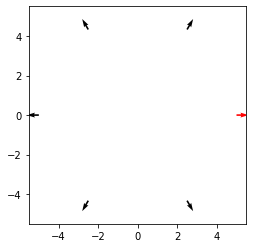

In [70]:
import matplotlib.pyplot as plt
import numpy as np
phi0=0*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
phiArr=np.arange(0, 6) * 4 * np.pi / 3
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    if rotations%2==1:
        mu = np.tan(rotations*rotationAngle/2)
        M_uc = np.asarray([[1 - mu ** 2, 2 * mu], [2 * mu, mu ** 2 - 1]]) * 1 / (1 + mu ** 2)  # reflection matrix
        mSym=M_uc@m
    else:
        M_Angle=rotationAngle*rotations
        MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
        mSym=MRot@m
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



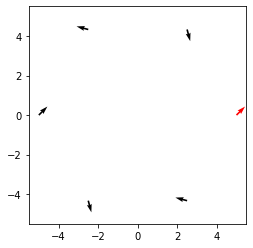

In [84]:
import matplotlib.pyplot as plt
import numpy as np
phi0=.5*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    M_Angle=rotationAngle*rotations
    MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
    mSym=MRot@m
    mSym*=(-1)**rotations
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [8]:
import numpy as np

a=np.array([0.22335083, 0.05468504, 0.01778291, 1.86398975, 5.89642321])
b=np.array([0.22336635, 0.05398954, 0.01994955, 2.174386  , 5.1246072 ])
c=np.array([0.22336904, 0.05486956, 0.01967456, 1.16595304, 4.66104557])
d=np.array([0.22232782 ,0.05411236 ,0.01467107 ,1.69968186 ,5.40909307])
e=np.array([0.2228413  ,0.05462561 ,0.01132046 ,1.28740702 ,5.31414559])
arr=np.column_stack((a,b,c,d,e))
np.std(arr,axis=1),np.mean(arr,axis=1)

(array([4.14115074e-04, 3.42908512e-04, 3.27518627e-03, 3.71033510e-01,
        4.01261604e-01]),
 array([0.22305107, 0.05445642, 0.01667971, 1.63828353, 5.28106293]))

In [11]:
#locked phi,locked theta, variable radius
a=np.array([0.2425    , 0.06891085, 0.02262274, 3.05662444, 0.02194268,
            0.06575895, 0.04839916, 5.17701814, 0.0254,.08078    ])
e=np.zeros(len(a))*np.nan
e[0]=.23
e[-1]=1.0

rowLabels=['L', 'r', 'deltaZ','psi','radius','r', 'deltaZ','psi','radius','cost']
colLabels=['param,SI','run1','baseline lens']
cellText=[]




cellText=[rowLabels,arrToStr(a),arrToStr(e)]
cellText=list(zip(*cellText))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.table(cellText=cellText,cellLoc ='center',loc ='upper left',colLabels=colLabels)
plt.savefig('poop',dpi=100)
plt.show()

5.235987755982989

[0.0, 0.0]


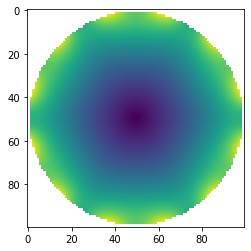

In [25]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254

DNAList=[]
phaseList=[0.0,0*np.pi/24]
print(phaseList)
for phase in phaseList:
    dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
    DNAList.append(dict)
lens=GeneticLens(DNAList)
xArr=np.linspace(-rp*.9,rp*.9,100)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
image=vals.reshape(len(xArr),len(xArr))
plt.imshow(image)
plt.show()

138495.08612143216


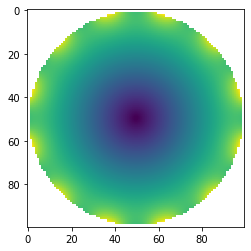

138423.34798352577


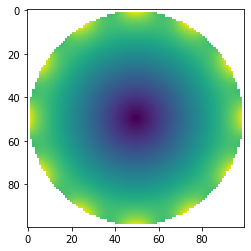

128008.7705542105


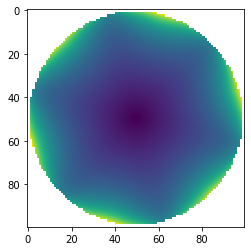

In [48]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254*10
def plot_Field(phaseList):
    DNAList=[]
    for phase in phaseList:
        dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
        DNAList.append(dict)
    lens=GeneticLens(DNAList)
    xArr=np.linspace(-rp*.9,rp*.9,100)
    coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
    vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
    vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
    image=vals.reshape(len(xArr),len(xArr))
    print(np.nansum(image))
    plt.imshow(image)
    plt.show()
plot_Field([0.0]*2)
plot_Field([np.pi/12]*2)
plot_Field([0.0,np.pi/6])

In [12]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt("data")

In [13]:
data

array([[ 5.00000000e+00,             nan,             nan,
                    nan],
       [ 6.00000000e+00,             nan,             nan,
                    nan],
       [ 7.00000000e+00,             nan,             nan,
                    nan],
       [ 8.00000000e+00,             nan,             nan,
                    nan],
       [ 9.00000000e+00,  9.64950040e-01,  1.00508048e+00,
         7.37933564e-12],
       [ 1.00000000e+01,  9.64860882e-01,  1.00497261e+00,
        -3.87047873e-12],
       [ 1.10000000e+01,  9.64883935e-01,  1.00512460e+00,
         3.89087191e-12],
       [ 1.20000000e+01,  9.64972302e-01,  1.00507125e+00,
         1.69545225e-11],
       [ 1.30000000e+01,  9.64969125e-01,  1.00509799e+00,
        -2.85799591e-12],
       [ 1.40000000e+01,  9.64954263e-01,  1.00503565e+00,
         2.40735088e-12],
       [ 1.50000000e+01,  9.64967604e-01,  1.00507673e+00,
        -8.77421807e-12],
       [ 1.60000000e+01,  9.65002542e-01,  1.00504317e+00,
      

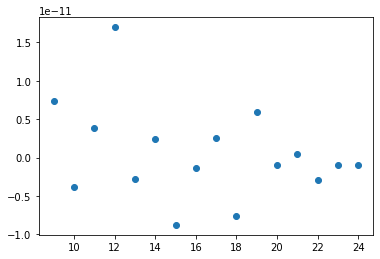

In [16]:
plt.scatter(data[:,0],data[:,3])
plt.show()

In [1]:
import matplotlib.pyplot as plt
from HalbachLensClass import Layer,SegmentedBenderHalbach
import numpy as np
from parallel_Gradient_Descent import gradient_Descent
from scipy.optimize import curve_fit
import multiprocess as mp
import time
rp0,rb0,Lm0,extraSpace0=.01,1.0,.0254/2.0,0.0
magnetWidth = rp0 * np.tan(2 * np.pi / 24) * 2
yokeWidth=magnetWidth
Lseg = Lm0 + extraSpace0 * 2
ucAng=np.arctan(Lseg/(2*(rb0-rp0-yokeWidth)))

Error: scikit-image not found. TVD will not work.


In [6]:

# numPointsGridEdge=500
# xArr=np.linspace(-rp0,rp0,numPointsGridEdge)
# coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
# def makge_And_Trim_Vals(lens,rp):
#     vals=np.asarray([np.linalg.norm(lens.B(np.asarray([coord]))) for coord in coords])
#     vals[np.linalg.norm(coords,axis=1)>=rp]=np.nan
#     vals[np.linalg.norm(coords,axis=1)<=.1*rp]=np.nan
#     return vals
# def nominal_Values(rp):
#     lens=Layer(0.0,.025,1.0,.05)
#     return makge_And_Trim_Vals(lens,rp)
# def error_Values(rp,amp=1.0):
#     np.random.seed(int(time.time()*1e6)%10_000)
#     rpMagnetShift=amp*.01*rp*(np.random.random_sample(12)-.5)
#     M_ShiftRelative=amp*.01*(np.random.random_sample(12)-.5)
#     thetaShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     phiShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     lens=Layer(0.0,.025,1.0,.05,rMagnetShift=rpMagnetShift,M_ShiftRelative=M_ShiftRelative,thetaShift=thetaShift,phiShift=phiShift)
#     return makge_And_Trim_Vals(lens,rp)
# valsNominal=nominal_Values(rp0)
# imageNominal=valsNominal.reshape((int(np.sqrt(len(valsNominal))),)*2)
# plt.imshow(imageNominal)
# plt.show()

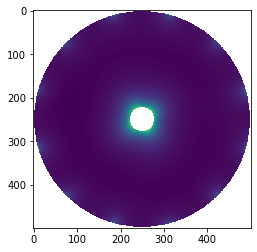

In [78]:
import multiprocess as mp
numRuns=100
with mp.Pool(8) as pool:
    errorResults=np.asarray(pool.map(error_Values,[rp0]*numRuns))
valsErrorRMS=np.std(errorResults,axis=0)
valsRelativeError=(valsErrorRMS/valsNominal)
imageRelativeError=valsRelativeError.reshape((int(np.sqrt(len(valsNominal))),)*2)
plt.imshow(imageRelativeError)
plt.show()

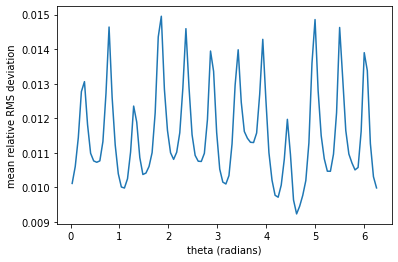

In [79]:
coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
valsNanTrimmed=valsRelativeError[~np.isnan(valsRelativeError)]
thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
thetaArr[thetaArr<0.0]+=2*np.pi
#
numBins=100
thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
errorThetaVals=errorThetaVals/thetaFrequency

binCenter=bins[:-1]+(bins[1]-bins[0])/2

plt.plot(binCenter,errorThetaVals)
plt.ylabel('mean relative RMS deviation')
plt.xlabel('theta (radians)')
plt.show()

In [81]:
# plt.semilogy(thetaArr,valsRelativeError,linewidth=0.0,marker='o',alpha=.1)
# plt.show()

for i in range(len(errorResults)):
    coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
    valsNanTrimmed=errorResults[i][~np.isnan(valsRelativeError)]-valsNominal[~np.isnan(valsRelativeError)]
    thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
    thetaArr[thetaArr<0.0]+=2*np.pi
    #
    numBins=100
    thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
    errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
    errorThetaVals=errorThetaVals/thetaFrequency

    binCenter=bins[:-1]+(bins[1]-bins[0])/2

    # plt.plot(binCenter,errorThetaVals)
    # plt.show()

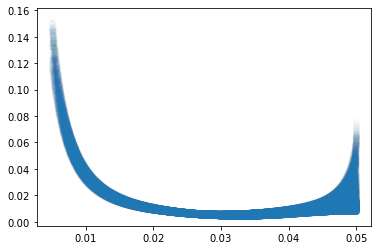

In [87]:
# plot radial dependence
rArr=np.sqrt(coords[:,0]**2+coords[:,1]**2)
plt.scatter(rArr,valsRelativeError,alpha=.01)
plt.show()

In [10]:
#where is the field the smallest in a bender, ie where is the center?

numLens=41
bender=SegmentedBenderHalbach(rp0,rb0,ucAng,Lm0,numLenses=numLens,positiveAngleMagnetsOnly=False)
thetaMaxGeom=np.arctan(Lm0*(numLens/2)/rb0)
thetaMax=Lm0/rb0
assert thetaMax<thetaMaxGeom/5.0 # assert small segment of total bend

In [42]:

def field_Val(deltaR,theta):
    if isinstance(deltaR,(tuple,list,np.ndarray)):
        deltaR=deltaR[0]
    r=rb0+deltaR
    x,y,z=np.cos(theta)*r,0.0,np.sin(theta)*r
    val=bender.BNorm(np.array([x,y,z]))
    return val
def find_rZero(theta):
    minFunc=lambda x: field_Val(x,theta)
    deltaR_Zero=gradient_Descent(minFunc,[0.0],30e-6,50,parallel=False,disp=False,gradStepSize=1e-6)[0][0]
    rZero=rb0+deltaR_Zero
    return rZero
numPoints=50
thetaArr=np.linspace(-1.0,1.0,numPoints)*thetaMax
with mp.Pool() as pool:
    rZeroArr=np.asarray(pool.map(find_rZero,thetaArr))
xZeroArr=np.array([r*np.cos(theta) for r,theta in zip(rZeroArr,thetaArr)])
zZeroArr=np.array([r*np.sin(theta) for r,theta in zip(rZeroArr,thetaArr)])

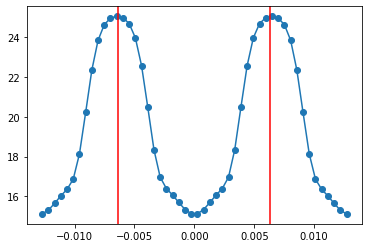

In [43]:
deltaRArr=(rZeroArr-rb0)/1e-6

plt.plot(thetaArr,deltaRArr)
plt.scatter(thetaArr,deltaRArr)
thetaLm=np.arctan(Lm0/rb0)
plt.axvline(x=thetaLm/2.0,c='r')
plt.axvline(x=-thetaLm/2.0,c='r')
# plt.gca().set_aspect('equal')
plt.show()

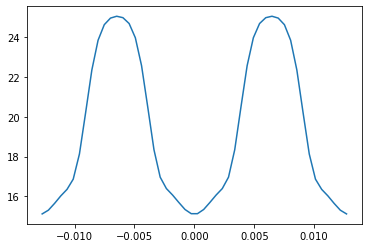

0.4951275810357077

In [46]:
#fit sines to the rZero depndence as a function of thea
y=deltaRArr.copy()
# y-=(y.max()+y.min())/2.0
# y/=y.max()
# y-=np.mean(y)
# y/=np.max(y)
a0=np.trapz(y*np.cos(0thetaArr),x=thetaArr)
plt.plot(thetaArr,y)
plt.show()
a0

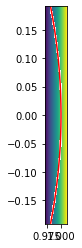

In [38]:
numPoints=100
xArr=np.linspace(rb0-(1-np.cos(thetaMax))*rb0-rp0,rp0+rb0,numPoints)
zArr=np.linspace(-1.0,1.0,numPoints)*thetaMax*rb0
coords=np.array(np.meshgrid(xArr,0.0,zArr)).T.reshape(-1,3)
vals=bender.BNorm(coords)
image=np.flip(vals.reshape(numPoints,numPoints),axis=0)
xImage=np.flip(coords[:,0].reshape(numPoints,numPoints),axis=0)
for rowX,rowVal in zip(xImage,image):
    rowX[np.nanargmin(rowVal)]=np.nan
    # print(np.min(rowVal))
plt.imshow(xImage,extent=[xArr.min(),xArr.max(),zArr.min(),zArr.max()])
plt.plot(xZeroArr,zZeroArr,c='r')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import time
from constants import MAGNETIC_PERMEABILITY
import numpy as np
from numpy.linalg import norm
from HalbachLensClass import magpy_Prism,solve_And_Update_Magnetization_Interactions,Layer
# %matplotlib inline
w=2e-2
M0=1e6
sepArr=np.arange(12)*w
prismList0=[]
for sep in sepArr:
    prismList0.append(magpy_Prism(0.0,sep,0.0,np.pi/2,w,w,M0))

# plt.imshow(image)
# plt.show()
solve_And_Update_Magnetization_Interactions(prismList0)
mList=[]
for prism in prismList0:
    # print(prism.get_M_Vector())
    mList.append(prism.get_M_Vector()[1])
plt.plot(sepArr,mList)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [2]:
sepArr=np.arange(3)*w
prismList0=[]
for sep in sepArr:
    prismList0.append(magpy_Prism(sep,0.0,0.0,0.0,w,w,M0))

solve_And_Update_Magnetization_Interactions(prismList0)
mList=[]
for prism in prismList0:
    # print(prism.get_M_Vector())
    mList.append(prism.get_M_Vector())
# plt.plot(sepArr,mList)
# plt.show()
np.std(mList,axis=0)[0],np.std(mList,axis=0)[1],np.std(mList,axis=0)[2] #(2226.6094640328656, 2.262469152603151e-13, 3.087685721856797e-13)

(2642.3685373389367, 2.1298666639971555e-14, 5.975545537050544e-14)

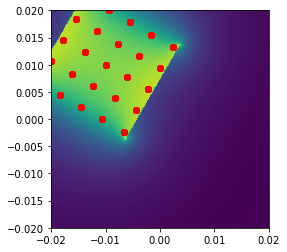

In [4]:
prism1=magpy_Prism(-0.01,0.01,0.0075,np.pi/3,w,w,M0)
# testCoordsXY=np.linspace(-.9*prism1.width/2,.9*prism1.width/2,5)
# testCoordsZ=np.linspace(-.9*prism1.length/2,.9*prism1.length/2,5)
# testCoords=np.array(np.meshgrid(testCoordsXY,testCoordsXY,testCoordsZ)).T.reshape(-1,3)
# R=prism1.magnet.orientation.as_matrix()
# testCoords=(R@testCoords.T).T
# testCoords+=np.asarray([.01,.01,.0075])
testCoords=prism1.sampleCoords

xArr=np.linspace(-w,w,200)
coords=np.array(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
vals=np.linalg.norm(prism1.B(coords),axis=1)
# vals[coords[:,0]==-.03]=np.nan
plt.scatter(testCoords[:,0],testCoords[:,1],c='r')
image=vals.reshape(len(xArr),len(xArr))
image=np.rot90(image)
plt.imshow(image,extent=[xArr.min(),xArr.max()]*2)
plt.show()

In [5]:
deltaB=.25*.1
deltaH=79.5*10_000
mu=MAGNETIC_PERMEABILITY
(1.28/mu)/1e6
704385.5015005864/79

8916.272170893499